In [115]:
from scipy.spatial import distance
from scipy.stats import norm
import pandas as pd
import numpy as np
from random import choices
import time
import sparse
from statsmodels.stats.multitest import multipletests as mt
from matplotlib import pyplot as plt

In [116]:
data = pd.read_csv("/media/austin/IPI_8plex_project/8plex/analysis/cell_data_tables/IPICRC055T1_8plex/IPICRC055T1_8plex_single_cell_data_gated_tumorannotated_20220131.csv")
in_tumor = 1 # 0 if analyzing stroma, 1 if analyzing tumor
data = data[data['in_tumor']==in_tumor]
ncells=len(data)

cell_types = list(set(data.cell_type))
try:
    cell_types.remove('other')
except KeyError:
    pass
ncell_types = len(cell_types)

bootstrap_num = 1000
close_num_rand = np.zeros((ncell_types, ncell_types, bootstrap_num))
distance_threshold= 100

In [117]:
centroid_coords = np.stack([data[data['in_tumor']==in_tumor]['centroid-0'],
                            data[data['in_tumor']==in_tumor]['centroid-1']]).astype(np.float32).transpose()

In [118]:
dist_mat = distance.cdist(centroid_coords, centroid_coords, metric="euclidean").astype(np.float32)

In [119]:
close_num = np.zeros((ncell_types, ncell_types), dtype=np.uint64)
close_rand = np.zeros((ncell_types, ncell_types, bootstrap_num), dtype=np.uint64)

for i in np.arange(ncell_types):
    
    ct1_pos_inds = (data['cell_type']==cell_types[i])
    n_ct1 = sum(ct1_pos_inds)

    for j in np.arange(ncell_types):
        
        ct2_pos_inds = (data['cell_type']==cell_types[j])
        n_ct2 = sum(ct2_pos_inds)

        grid = np.ix_(ct1_pos_inds, ct2_pos_inds)
        close_num[i, j] += np.sum(dist_mat[grid]<distance_threshold)

        for r in np.arange(bootstrap_num):
            ct1_rand_inds = np.random.choice(np.arange(ncells), size=n_ct1, replace=True)
            ct2_rand_inds = np.random.choice(np.arange(ncells), size=n_ct2, replace=True)
            
            grid = np.ix_(ct1_rand_inds, ct2_rand_inds)
            close_rand[i, j, r] += np.sum(dist_mat[grid]<distance_threshold)
            

In [120]:
z = np.zeros((ncell_types,ncell_types))
muhat = np.zeros((ncell_types,ncell_types))
sigmahat = np.zeros((ncell_types,ncell_types))
p = np.zeros((ncell_types, ncell_types, 2))

In [121]:
for j in np.arange(ncell_types):
    for k in np.arange(ncell_types):
        
        mu, sigma = norm.fit(close_rand[j,k,:])
        muhat[j,k]=mu
        sigmahat[j,k]=sigma
        
        z[j,k] = (close_num[j,k]-muhat[j,k])/sigmahat[j,k]
        p[j,k,0] = (1+(sum(close_rand[j,k,:]>=close_num[j,k])))/(bootstrap_num+1)
        p[j,k,1] = (1+(sum(close_rand[j,k,:]<=close_num[j,k])))/(bootstrap_num+1)


In [122]:
# adjust p-values using FDR 0.05 (Inf or NaN will have p value 1)
p_summary = p[:,:,1];
for j in np.arange(ncell_types):
    for k in np.arange(ncell_types):
        # if interaction is enriched +z grab first p-value
        if (z[j,k] > 0):
            p_summary[j,k] = p[j,k,0];
        # if interaction is avoided -z grab second p-value
        elif (z[j,k] < 0):
            p_summary[j,k] = p[j,k,1];
        

In [123]:
h, crit_p, adj_ci_cvrg, adj_p = mt(p_summary, alpha=0.05, method='fdr_bh')

/tmp/ipykernel_85963/1859720398.py:22: UserWarning: FixedFormatter should only be used together with FixedLocator
  axmatrix.set_xticklabels(['']+[cell_types[i] for i in index])
/tmp/ipykernel_85963/1859720398.py:23: UserWarning: FixedFormatter should only be used together with FixedLocator
  axmatrix.set_yticklabels(['']+[cell_types[i] for i in index])
/tmp/ipykernel_85963/1859720398.py:36: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


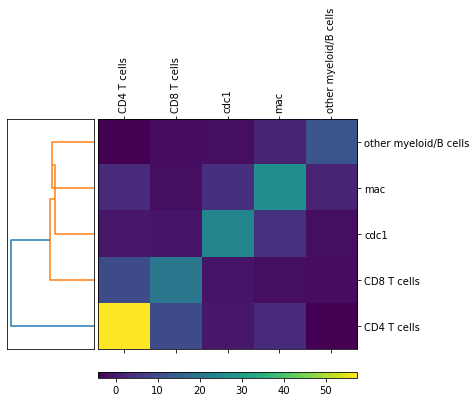

In [124]:
import scipy
import pylab
import scipy.cluster.hierarchy as sch

# Compute and plot dendrogram.
fig = pylab.figure()
axdendro = fig.add_axes([0.09,0.1,0.2,0.8])
Y = sch.linkage(z, method='centroid')
Z = sch.dendrogram(Y, orientation='left')
axdendro.set_xticks([])
axdendro.set_yticks([])

# Plot distance matrix.
axmatrix = fig.add_axes([0.3,0.1,0.6,0.8])
index = Z['leaves']
z = z[index,:]
z = z[:,index]
im = axmatrix.matshow(z, aspect='auto', origin='lower')
#axmatrix.set_xticks([])
#axmatrix.set_yticks([])

axmatrix.set_xticklabels(['']+[cell_types[i] for i in index])
axmatrix.set_yticklabels(['']+[cell_types[i] for i in index])

axmatrix.yaxis.set_label_position("right")
axmatrix.yaxis.tick_right()

plt.xticks(rotation=90)

# Plot colorbar.
axcolor = fig.add_axes([0.3,0.0,0.6,0.02])
plt.colorbar(im, cax=axcolor,orientation='horizontal')


# Display and save figure.
fig.show()
#fig.savefig('dendrogram.png')